# Project Milestone P4: Creative Extension

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Wrangling
### Loading Datasets

* `paper_dataset`: full dataset from paper, with all variables loaded
* `ucdp_prio_data`: raw UCDP Prio dataset with conflict ID and location
* `paper_data_countries` : dataset which links `cowcode`, `cid`, `id` and `country`. 
* `paper_data_merged`: full dataset from paper, with countries specified (merged on `cid` and `year`)
* `ged_201`: dataset after 1989 with conflict id and geographical location (used for conflicts of type 2)
* `ucdp_wrangled`: UCDP data with geographical location for all conflict types
* `joined`: `ucdp_wrangled` joined with paper data, with binary `war` variable
* `wiid_gini_raw`: WIID inequality dataset, raw
* `ineq_gini`: country, year, gini data from WID
* `df_gini_clean`: final dataset with Gini score
* `df_no_gini_clean`: final dataset without Gini score

In [151]:
# Global configuration for running
CFG = {
    "plot_heatmaps" : False,
    "cross_val" : False,
    "matching" : True
}

In [3]:
DATA_FOLDER = "data/"
ORIGINAL_PAPER_DATA = DATA_FOLDER + "SambnisImp.csv"
ORIGINAL_PAPER_COUNTRY = DATA_FOLDER + "sambanis_countries.dta"
UCDP_PRIO_DATA = DATA_FOLDER + "ucdp-prio-acd-201-csv.zip"
#UCDP_ACTOR_DATA = DATA_FOLDER + "ucdp-actor-201.xlsx"
WID_DATA_FOLDER = DATA_FOLDER + "wid_all_data/"
GED_201 = DATA_FOLDER + "ged201-csv.zip"

**Dataset from Muchlinski et al. paper**

In [4]:
paper_dataset = pd.read_csv(ORIGINAL_PAPER_DATA)
paper_dataset.head()

,Unnamed: 0,atwards,X,id,cid,cowcode,year,warstds,ptime,yrint,...,decade1,decade2,decade3,decade4,independ,tip,anocracy,proxregc,sxpnew.2,sxpsq.2
0,1,0,1,1.0,1,700,1945,0,12,0,...,0,0,0,0,1,17.0,0,0.143299,0.094095,0.094095
1,2,0,2,1.0,1,700,1946,0,24,1,...,0,0,0,0,1,18.0,0,1.000000,0.094547,0.094547
2,3,0,3,1.0,1,700,1947,0,36,2,...,0,0,0,0,1,19.0,0,1.000000,0.095567,0.095567
3,4,0,4,1.0,1,700,1948,0,48,3,...,0,0,0,0,1,20.0,0,1.000000,0.101303,0.101303
4,5,0,5,1.0,1,700,1949,0,60,4,...,0,0,0,0,1,21.0,0,1.000000,0.092107,0.092107


**UDCP Dataset**

In [5]:
#ucdp_actor_data = pd.read_excel(UCDP_ACTOR_DATA, sheet_name='Dataset')
#ucdp_actor_data.head()

In [6]:
ucdp_prio_cols = ['conflict_id', 'year', 'intensity_level', 
                  'cumulative_intensity', 'type_of_conflict', 'location',
                 'territory_name']
ucdp_prio_data = pd.read_csv(UCDP_PRIO_DATA, usecols=ucdp_prio_cols)
ucdp_prio_data.head()

,conflict_id,location,territory_name,year,intensity_level,cumulative_intensity,type_of_conflict
0,11342,India,Garoland,2012,1,0,3
1,11342,India,Garoland,2014,1,0,3
2,11343,"Egypt, Israel",Suez/Sinai,1967,2,1,2
3,11343,"Egypt, Israel",Suez/Sinai,1969,1,1,2
4,11343,"Egypt, Israel",Suez/Sinai,1970,1,1,2


**GED Dataset**

In [156]:
ged_201 = pd.read_csv(GED_201, usecols=['conflict_new_id','country','year'])
ged_201.sample(5)

,year,conflict_new_id,country
211172,2006,423,Thailand
133533,2008,337,Somalia
189379,2015,299,Syria
35079,1998,386,Algeria
99897,1989,332,Mozambique


In [8]:
#ged_201['country']
#ged_201[ged_201['conflict_new_id']==418]['country']
#ged_201.loc[221865]

## Plotting variables to visually check correlation with oil

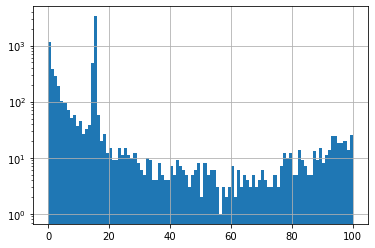

In [9]:
paper_dataset["fuelexp"].hist(bins=100).set_yscale('log')

In [138]:
#paper_dataset["fuel"].hist(bins=100).set_yscale('log')

In [139]:
#paper_dataset[paper_dataset["oil"] == 1]["fuelexp"].hist(bins=100).set_yscale('log')

In [140]:
#paper_dataset[paper_dataset["oil"] == 0]["fuelexp"].hist(bins=100).set_yscale('log')

In [142]:
#paper_dataset[paper_dataset["oil"] == 1]["fuel"].hist(bins=100).set_yscale('log')

In [141]:
#paper_dataset[paper_dataset["oil"] == 0]["fuelexp"].hist(bins=100).set_yscale('log')

In [15]:
# cid uniquely identifies a country, however in some cases when a country splits we have the 
# same CID for 2 different names in different years. This might be solved by joining on (year, cid)

paper_data_countries = pd.read_stata(ORIGINAL_PAPER_COUNTRY, columns=["country", "cid", "year"]).drop_duplicates()
#paper_data_countries.sample(10)
#paper_data_countries[paper_data_countries[["year", "cid"]].duplicated(keep=False)]

#paper_data_countries[paper_data_countries["country"] == "Czechoslovakia"]

In [144]:
# Note to future selves: we lost Korea 1945-1949
paper_data_merged = paper_data_countries.merge(paper_dataset, on=["cid", "year"])

In [145]:
paper_data_merged.sample(5)

,country,cid,year,Unnamed: 0,atwards,X,id,cowcode,warstds,ptime,...,decade1,decade2,decade3,decade4,independ,tip,anocracy,proxregc,sxpnew.2,sxpsq.2
2656,Honduras,66.0,1950.0,2657,0,3646,59.0,91,0,72,...,0,0,0,0,1,27.0,1,1.000000e+00,0.091451,0.091451
5784,Sri Lanka,138.0,1974.0,5785,0,7702,126.0,780,0,312,...,0,1,0,0,1,26.0,0,8.880000e-16,0.088912,0.088912
5500,Sierra Leone,130.0,1978.0,5501,0,7258,120.0,451,0,228,...,0,1,0,0,1,17.0,0,2.441410e-04,0.100613,0.100613
2087,Finland,52.0,1980.0,2088,0,2892,45.0,375,0,432,...,0,0,1,0,1,63.0,0,8.470000e-22,-0.737620,-0.737620
1191,Chile,32.0,1946.0,1192,0,1738,29.0,155,0,24,...,0,0,0,0,1,56.0,1,1.000000e+00,0.092626,0.092626


In [147]:
paper_data_merged[["country", "fuelexp", "year"]].sample(5)

,country,fuelexp,year
6460,U.K.,2.571990,1972.0
7109,Zimbabwe,15.289544,1970.0
762,Brazil,15.056692,1962.0
2214,Gambia,15.450700,1974.0
5710,Spain,15.315629,1953.0


#### Heatmaps

In [149]:
def plot_val_by_country_year(df, val, years=None):
    pivot = pd.pivot_table(data=df, columns=["year"], index="country", values=[val])
    pivot.columns = [int(x[1]) for x in pivot.columns]
    
    if years:
        pivot_slice = pivot[years]
    else:
        pivot_slice = pivot
    
    plt.figure(figsize=(20, 40))
    ax = sns.heatmap(pivot_slice, cmap='RdYlGn_r', linewidths=0.5)
    ax.set_title(val)
    plt.show()

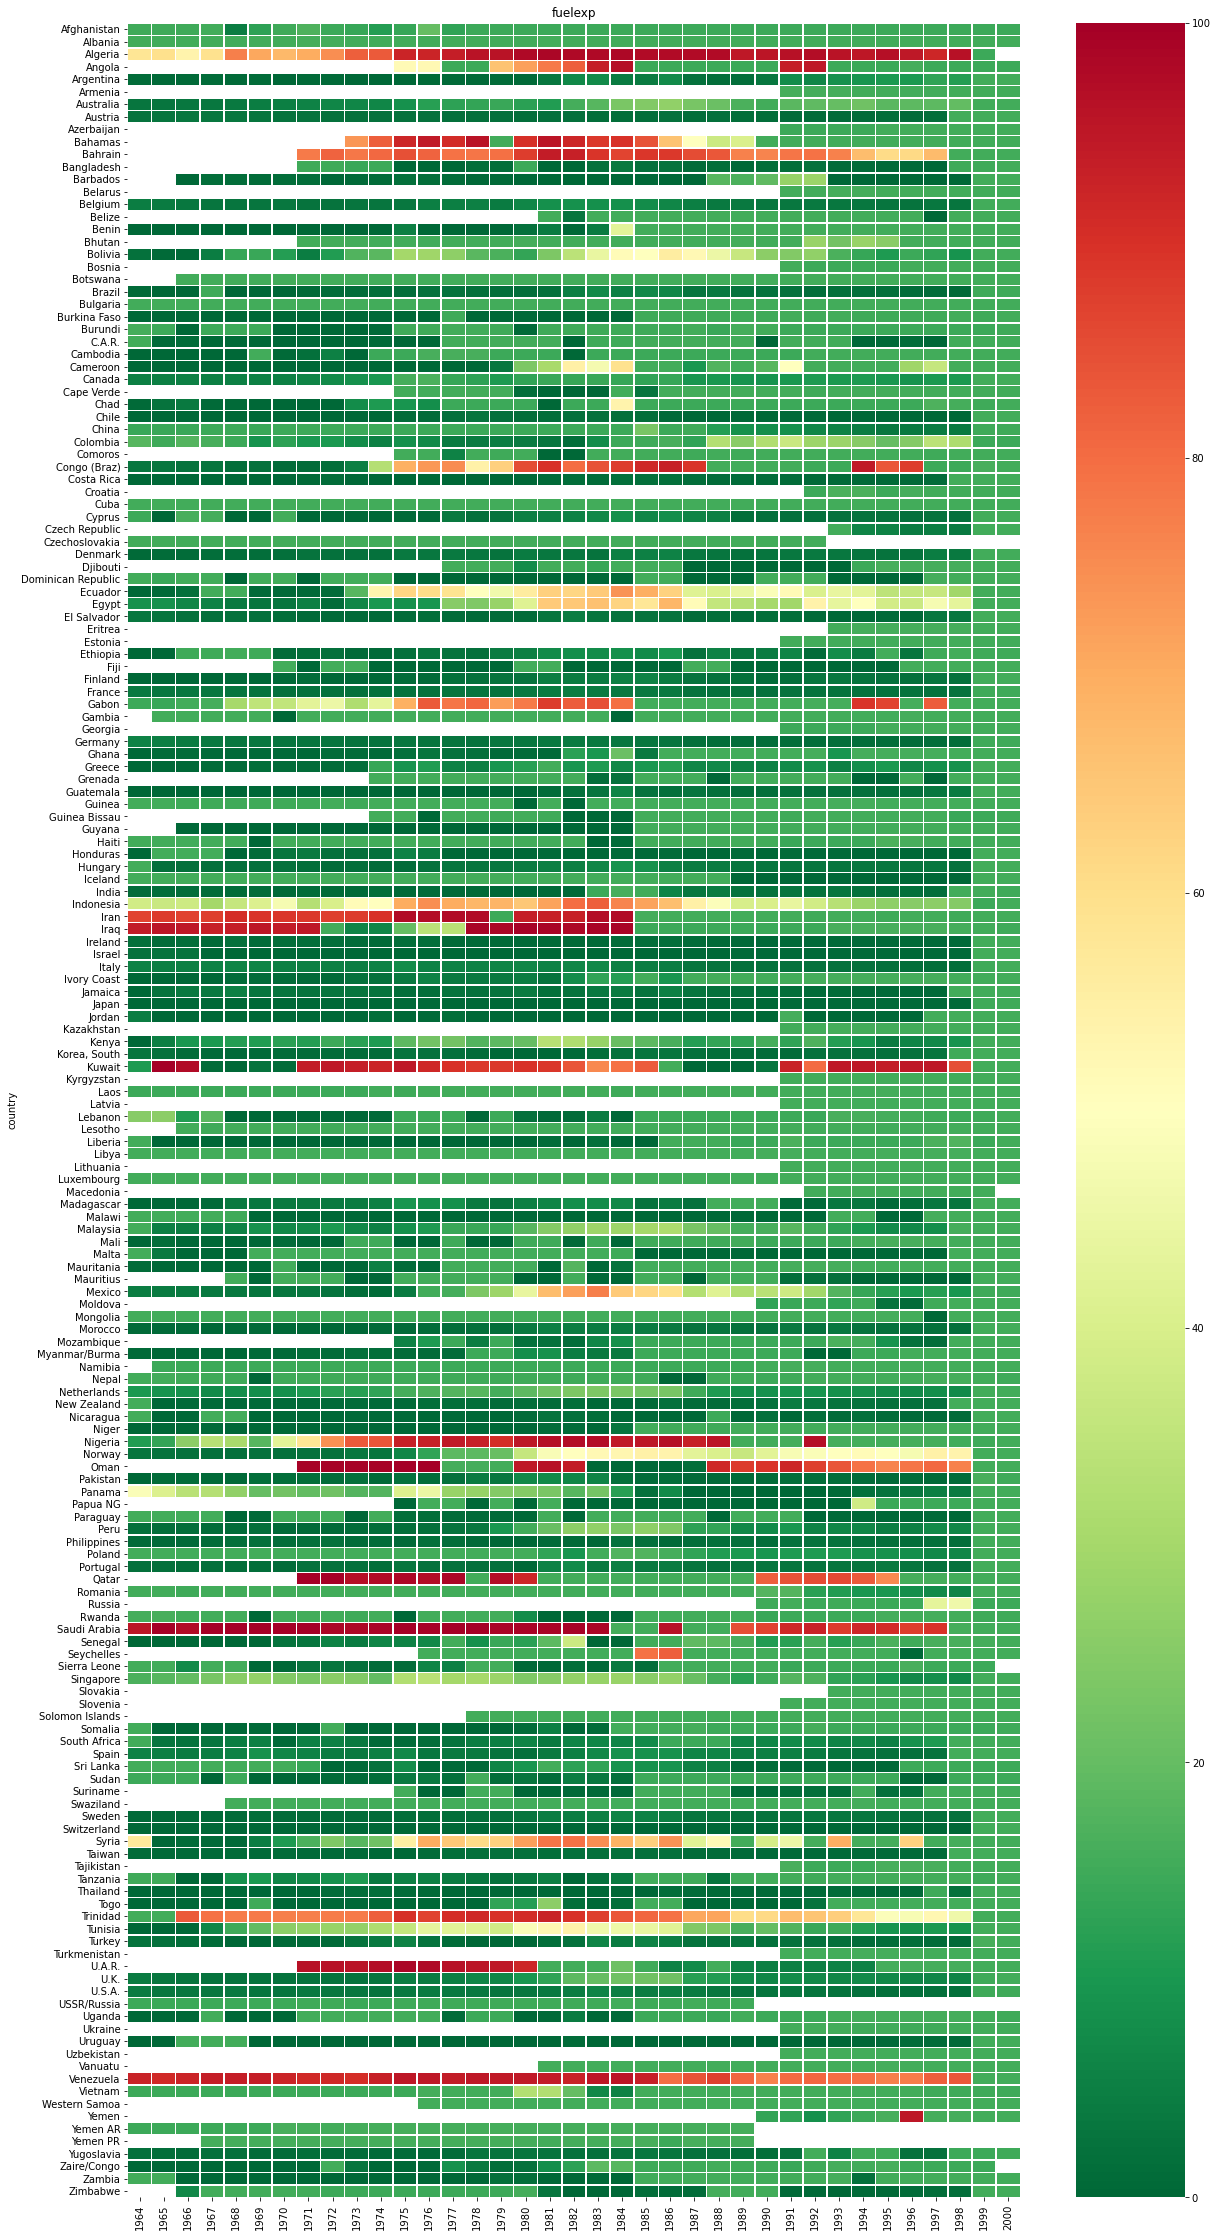

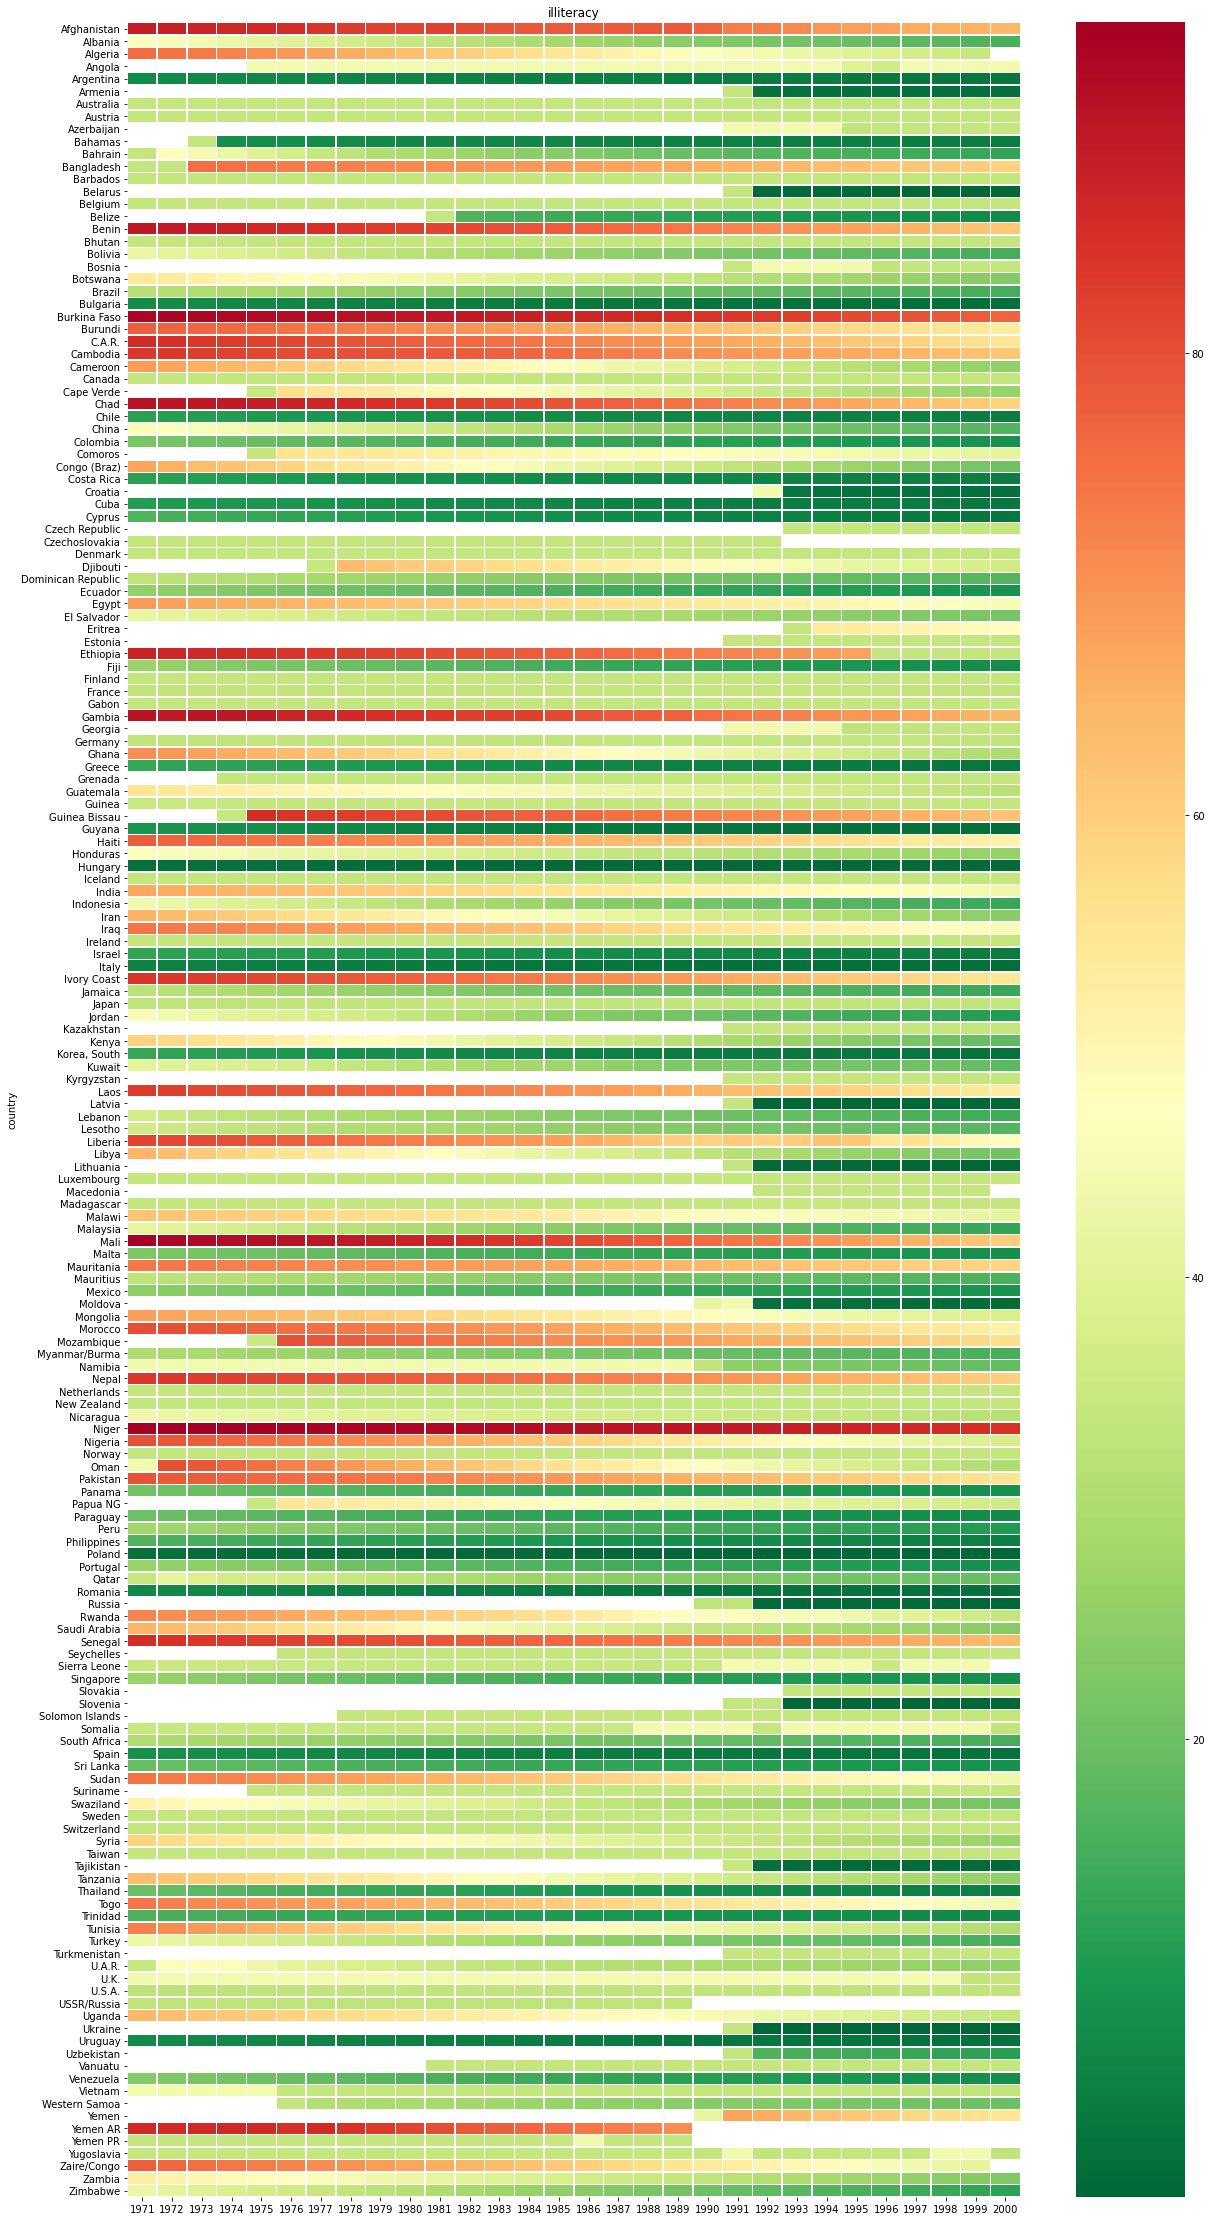

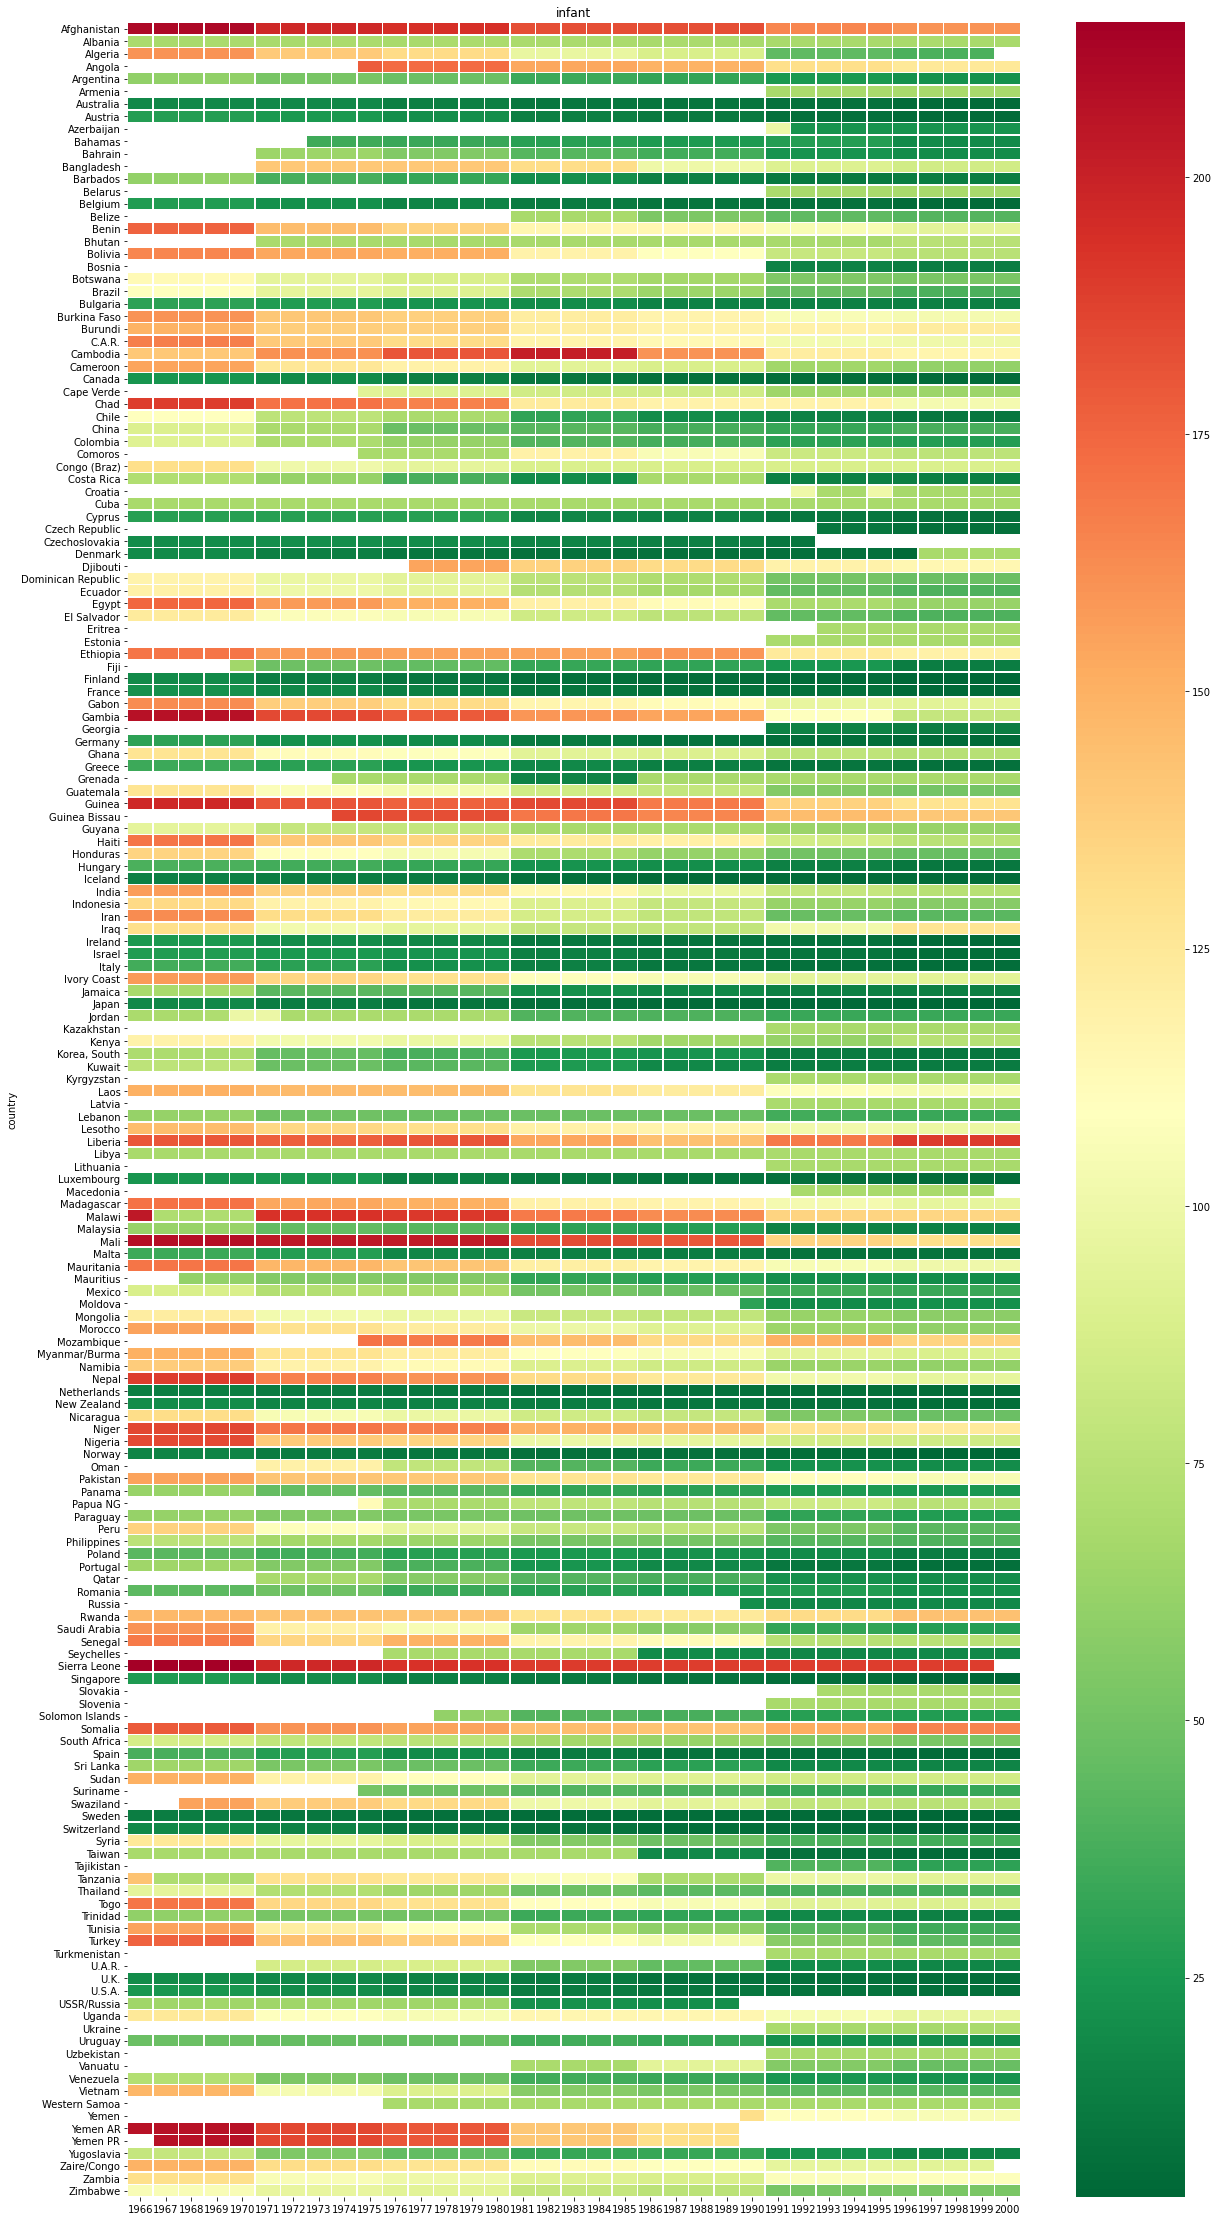

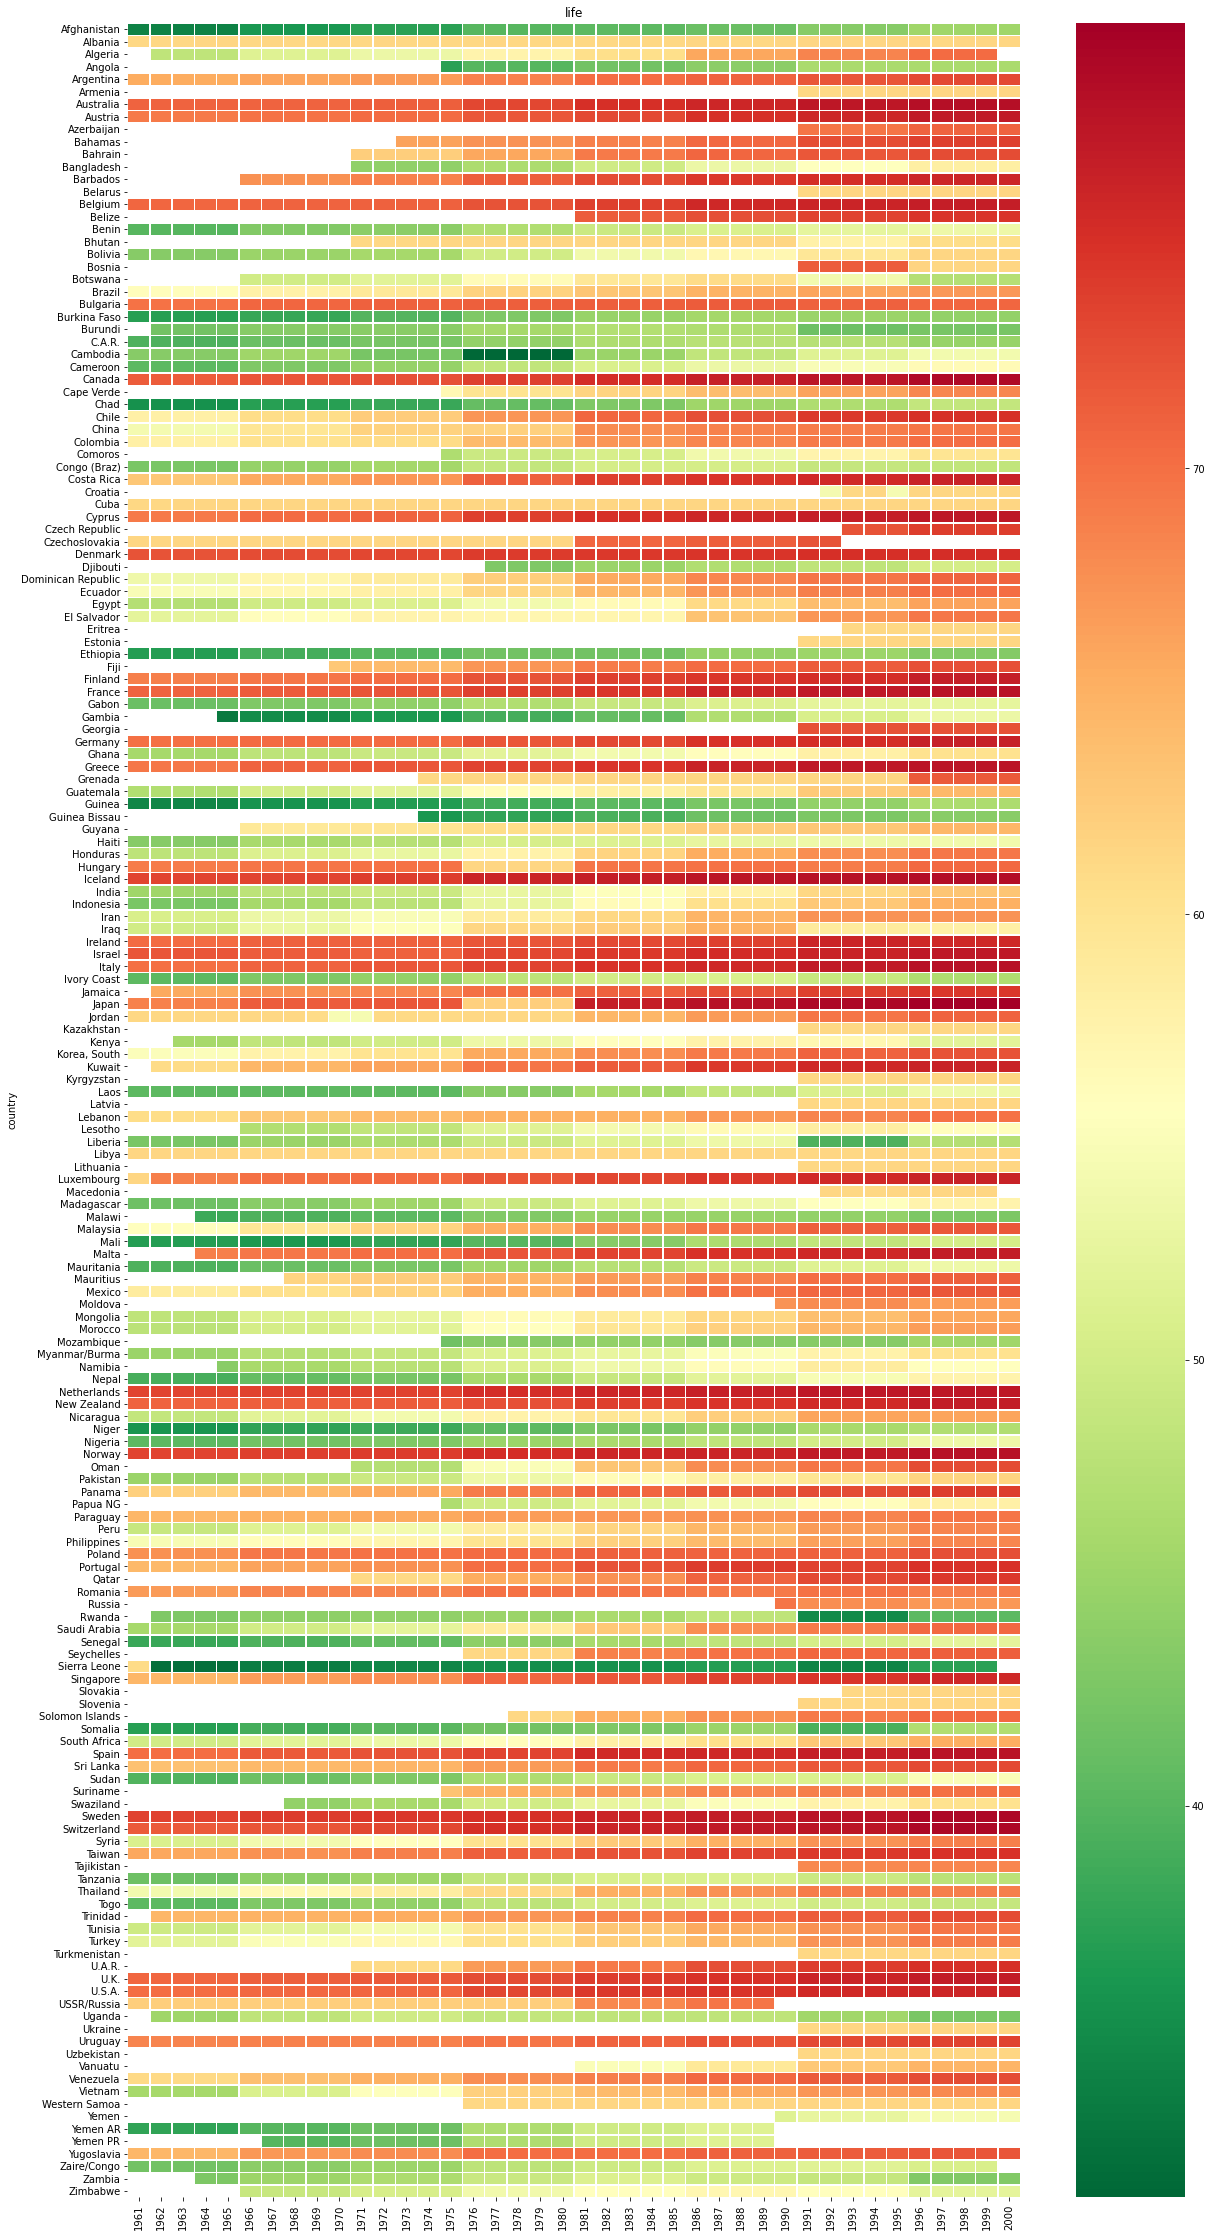

In [150]:
# TODO: comment on valid years from heatmaps?
if CFG["plot_heatmaps"]:
    plot_val_by_country_year(paper_data_merged, "fuelexp", years=range(1964, 2001))
    plot_val_by_country_year(paper_data_merged, "illiteracy", years=range(1971, 2001))
    plot_val_by_country_year(paper_data_merged, "infant", years=range(1966, 2001))
    plot_val_by_country_year(paper_data_merged, "life", years=range(1961, 2001))
    #plot_val_by_country_year(paper_data_merged, "gdpgrowth")

## Data wrangling for wars in territories

1. Get a row for each territory there was a war in for each year
2. For each country that was at war, match name with existing database
2. We need some data cleaning: US never had a war in its territory!
3. For each year, add a 'war in' column in the existing database for each country + intensity level


In [21]:
# 1 extra-systemic (state vs non-state in state territory to keep control of the system) <- colonies
# 2 inter-state  
# 3 intra-state
# 4 intra-state internationalized

In [154]:
# In this case, war is fought in location : we got this
ucdp_prio_data[ucdp_prio_data.type_of_conflict == 1].sample(5)

,conflict_id,location,territory_name,year,intensity_level,cumulative_intensity,type_of_conflict
1043,279,Guinea-Bissau,Guinea-Bissau,1966,1,1,1
802,256,"Mauritania, Morocco",Morocco/Mauritania,1958,1,0,1
868,263,Angola,Angola,1962,2,1,1
161,201,Cambodia (Kampuchea),Cambodia,1953,1,0,1
798,254,Cameroon,Cameroon,1958,1,0,1


In [163]:
# Not clear where the conflict was: however, only 48 conflicts: we can classify manually
ucdp_prio_data[ucdp_prio_data.type_of_conflict == 2]

,conflict_id,location,territory_name,year,intensity_level,cumulative_intensity,type_of_conflict
2,11343,"Egypt, Israel",Suez/Sinai,1967,2,1,2
3,11343,"Egypt, Israel",Suez/Sinai,1969,1,1,2
4,11343,"Egypt, Israel",Suez/Sinai,1970,1,1,2
5,11343,"Egypt, Israel",Suez/Sinai,1973,2,1,2
31,11348,"South Sudan, Sudan",Common border,2012,1,0,2
...,...,...,...,...,...,...,...
2277,409,"Eritrea, Ethiopia",Common border,2016,1,1,2
2354,420,"Australia, Iraq, United Kingdom, United States...",NaN,2003,2,1,2
2401,427,"Tanzania, Uganda",Kagera Salient,1978,1,0,2
2414,431,"Afghanistan, Russia (Soviet Union)",NaN,1979,1,0,2


In [165]:
# In this case, war is fought in location : we got this
ucdp_prio_data[ucdp_prio_data.type_of_conflict == 3].sample(5)

,conflict_id,location,territory_name,year,intensity_level,cumulative_intensity,type_of_conflict
933,266,DR Congo (Zaire),South Kasai,1962,1,0,3
32,11349,China,East Turkestan,2008,1,0,3
1445,309,Sudan,NaN,2013,1,1,3
1888,347,India,Manipur,1995,1,0,3
1382,308,Philippines,Mindanao,1987,1,1,3


In [166]:
#ucdp_prio_data[(ucdp_prio_data.type_of_conflict == 3) & (ucdp_prio_data.intensity_level == 1) & (ucdp_prio_data.location == 'United Kingdom')]

In [167]:
#ucdp_prio_data[(ucdp_prio_data.type_of_conflict != 2) & (ucdp_prio_data.location.str.contains('United States'))]

In [29]:
# Idea: always match countries with others that have the same intensity of war. Keep all intensities. 

## Selecting useful columns from datasets and merging on conflict id
To know the geographic location of war we merge the USCP/PRIO dataset with the disgragated dataset(ged-201) in order to have a new dataset with important information for data analysis. So we did a filtering on the columns of the two datasets and we merged using the feature conflic_id_new, for the disgragated dataset, and the feature conflict_id for the USCD/PRIO dataset. These two features are fully compatible and identify a specific conflict.
Using USCP dataset we select conflicts with types of conflict equal to 1, 3 or 4 (extrasystemic, intrastate, internationalzed intrastate) because in these cases the location correspond to the geografic location which is not true in general. For conflicts of type 2 (interstates) we use the merging as described above for conflicts starting from 1989, for the others we 'build' the geographic location manually using the geografic area. 

In [195]:
# merging ged_201 and ucdp_prio 
#conflict_merged = pd.merge(ged_201, ucdp_prio_data, left_on= ['conflict_new_id','year'], right_on =['conflict_id','year']).drop_duplicates()

In [196]:
#conflict_merged[(conflict_merged['year']>1959) & (conflict_merged['year']<=2000)].sample(5)

In [197]:
#if "conflict_new_id" in conflict_merged:
#    conflict_merged.drop('conflict_new_id', axis=1, inplace=True)
#    print ("Done")

In [33]:
#conflict_merged[conflict_merged['conflict_id']==315]
#ged_201[ged_201['conflict_new_id']==315].year
ged_201['year'].min()

1989

#### Selecting conflicts of types (1,3,4)

Select conflicts of type 1, 3 and 4 between 1961 and 2000 where "location" means geographic location.

In [170]:
# Filter years between 1961 and 2000
ucdp_prio_data_1961_2000 = ucdp_prio_data[(ucdp_prio_data['year']>1960) & (ucdp_prio_data['year']<=2000)]
# filter conflicts of type 1, 3, 4 between 1961 and 2000
ucdp_prio_data_134 = ucdp_prio_data_1961_2000[ucdp_prio_data_1961_2000['type_of_conflict'] != 2]

#### Selecting conflicts of type 2 after the 1989

In [171]:
# filter conflicts of type 2 between 1961 and 2000
ucdp_prio_data_2 = ucdp_prio_data_1961_2000[ucdp_prio_data_1961_2000['type_of_conflict'] == 2]

In [36]:
# view conflicts of type 2 between 1961 and 2000
ucdp_prio_data_2[ucdp_prio_data_2['year']>1988].head()

,conflict_id,location,territory_name,year,intensity_level,cumulative_intensity,type_of_conflict
291,218,"India, Pakistan",Kashmir,1989,1,1,2
292,218,"India, Pakistan",Kashmir,1990,1,1,2
293,218,"India, Pakistan",Kashmir,1991,1,1,2
294,218,"India, Pakistan",Kashmir,1992,1,1,2
295,218,"India, Pakistan",Kashmir,1996,1,1,2


In [217]:
# merging with ged_201 to have the geographical location for conflicts after 1989
ucdp_2_after1989 = pd.merge(ged_201, ucdp_prio_data_2, 
                            left_on= ['conflict_new_id','year'], 
                            right_on =['conflict_id','year']).drop_duplicates()

In [218]:
# drop "location" and "conflict_new_id", then rename country to "location". 
# Now location is geographical location

ucdp_2_drop_cols = ["conflict_new_id", "location"]
if all([col in ucdp_2_after1989 for col in ucdp_2_drop_cols]):
    ucdp_2_after1989.drop(ucdp_2_drop_cols, axis=1, inplace=True)
    print(f"Dropped: {ucdp_2_drop_cols}")

ucdp_2_after1989.rename(columns = {"country" : "location"}, inplace=True)
ucdp_2_after1989.sample(5)

Dropped: ['conflict_new_id', 'location']


,year,location,conflict_id,territory_name,intensity_level,cumulative_intensity,type_of_conflict
62,1989,India,218,Kashmir,1,1,2
32,1998,Ethiopia,409,Common border,2,1,2
7,1995,Peru,403,Cordillera del Condor,1,0,2
63,1990,India,218,Kashmir,1,1,2
223,1991,Kuwait,371,Kuwait,2,1,2


#### Selecting manually the location of interstate conflicts (2) before 1989

In [219]:
# before 1970
ucdp_before_1970 = ucdp_prio_data_2[ucdp_prio_data_2['year'] < 1970].copy()
ucdp_before_1970["location"] = ucdp_before_1970["location"].str.split(', ') # split on comma
ucdp_before_1970_exp = ucdp_before_1970.explode("location") # explode split rows

ucdp_before_1970_exp.index = range(2500, 2500+len(ucdp_before_1970_exp)) # reassign index 
ucdp_before_1970_exp.sample(5) 

,conflict_id,location,territory_name,year,intensity_level,cumulative_intensity,type_of_conflict
2510,272,France,Bizerte,1961,2,1,2
2518,278,Algeria,Common Border,1963,1,0,2
2505,218,Pakistan,Kashmir,1964,1,1,2
2512,274,China,"Aksai Chin, Arunachal Pradesh",1962,2,1,2
2526,281,Indonesia,North Borneo,1966,1,0,2


In [220]:
# Drop countries where the war did not take place
udcp_before_1970_manual = ucdp_before_1970_exp.drop([
    2501, # Israel Suez
    2503, # Israel Suez
    2509, # Somalia Ogaden
    2510, # France 1961 (vs Tunisia)
    2517, # France 1961 (vs Tunisia)
    2529, # North Vietnam 1965
    2531, # North Vietnam 1965
    2533, # North Vietnam 1965
    2535, # North Vietnam 1965
    2537, # North Vietnam 1965
    2540, # Israel Golan
])

In [221]:
# Same as above for conflicts between 1980 and 1988
df_1988 = ucdp_prio_data[(ucdp_prio_data.type_of_conflict == 2) & (ucdp_prio_data.year >= 1980) & (ucdp_prio_data.year<=1988)].copy()
df_1988["location"] = df_1988["location"].str.split(', ')
df_1988_exploded = df_1988.explode("location")
df_1988_exploded.index = range(2700, 2700+len(df_1988_exploded))
udcp_before_1988_manual = df_1988_exploded.drop([2739, 2743, 2707])

In [222]:
# Same as above for conflicts between 1970 and 1980
ucdp_before_1980 = ucdp_prio_data_2[(ucdp_prio_data_2['year']>1970) & (ucdp_prio_data_2['year']<1980)].copy()
ucdp_before_1980["location"] = ucdp_before_1980["location"].str.split(', ')
ucdp_before_1980_exp = ucdp_before_1980.explode("location")
ucdp_before_1980_exp.index = list(range(2600, 2600+len(ucdp_before_1980_exp)))
ucdp_before_1980_manual = ucdp_before_1980_exp.drop([2601 # Israel Suez
                           ,2605 # Somalia Ogaden
                           ,2607,# Somalia Ogaden
                           2609, # Somalia Ogaden
                           2611, #North Vietnam
                           2613, #North Vietnam
                           2615, #North Vietnam
                           2617, #North Vietnam
                           2622, #Israel Golan
                           2629, #Turkey north cyprus
                           2645, #Uganda Kagera Salient
                           2647, #Russia
                          ])

In [223]:
# concatenate all conflicts of level 2
ucdp_manual = pd.concat([udcp_before_1970_manual, ucdp_before_1980_manual, udcp_before_1988_manual])
ucdp_conflict_level2 = pd.concat([ucdp_manual, ucdp_2_after1989])
ucdp_conflict_level2.sample(5)

,conflict_id,location,territory_name,year,intensity_level,cumulative_intensity,type_of_conflict
29,409,Eritrea,Common border,1998,2,1,2
2733,334,Vietnam (North Vietnam),Various,1986,1,1,2
2750,356,Laos,Common Border,1988,1,0,2
2639,334,Vietnam (North Vietnam),Various,1974,1,0,2
2521,281,Malaysia,North Borneo,1963,1,0,2


In [224]:
# concatenate all conflicts
filtercols = ["location", "year", "conflict_id", "intensity_level", 
              "cumulative_intensity", "territory_name"]#, "region"]
ucdp_wrangled = pd.concat([ucdp_prio_data_134, ucdp_conflict_level2])[filtercols].sort_values(by="year")

ucdp_wrangled.sample(5)

,location,year,conflict_id,intensity_level,cumulative_intensity,territory_name
1313,Syria,1982,299,2,1,NaN
1861,Spain,1979,342,1,0,Basque
2209,Georgia,1993,392,2,1,Abkhazia
810,Iraq,1983,259,1,1,NaN
868,Angola,1962,263,2,1,Angola


In [233]:
# Standardize names
name_map = {
    "Bosnia" : "Bosnia-Herzegovina",
    "Cambodia (Kampuchea)" : "Cambodia",
    "Congo" : "Congo (Braz)",
    "Zaire/Congo" : "DR Congo (Zaire)",
    "Guinea Bissau" : "Guinea-Bissau",
    "Papua NG" : "Papua New Guinea",
    "Madagascar (Malagasy)" : "Madagascar",
    "Myanmar/Burma" : "Myanmar (Burma)",
    "USSR/Russia" : "Russia (Soviet Union)",
    "Serbia (Yugoslavia)" : "Yugoslavia",
    "Trinidad" : "Trinidad and Tobago",
    "United Kingdom" : "U.K.",
    "Yemen (North Yemen)" : "Yemen", # TODO: review
    "South Yemen" : "Yemen", # TODO: review
    "Zimbabwe (Rhodesia)" : "Zimbabwe",
    "Vietnam (North Vietnam)" : "Vietnam"
}


# substitute names
#paper_features = ["country", "life", "fuelexp", "year", "illiteracy", "infant"]
#paper_wellbeing = paper_data_merged[paper_features].copy()
paper_wellbeing = paper_data_merged # rename
paper_wellbeing.country = [name_map.get(x, x) for x in paper_wellbeing.country]
ucdp_wrangled.location = [name_map.get(x, x) for x in ucdp_wrangled.location]

# year as int
paper_wellbeing.year = paper_wellbeing.year.astype(int)

# rename Vietnam before unification to South Vietnam
# Data before unification is very likely only from South Vietnam
vietnam_index = paper_wellbeing[(paper_wellbeing["country"] == "Vietnam") & (paper_wellbeing["year"] < 1976)].index
paper_wellbeing.loc[vietnam_index, "country"] = "South Vietnam"

In [227]:
# drop North Vietnam before 1976
dropped_vietnam = False
if not dropped_vietnam:
    ucdp_wrangled.drop([2639, 2633], inplace=True)
    dropped_vietnam = True

In [234]:
# change Russia to USSR in 1990 and 1991 (this is likely a mistake)
russia_index = paper_wellbeing[(paper_wellbeing["country"] == "Russia") & (paper_wellbeing["year"] <= 1991)].index
paper_wellbeing.loc[russia_index, "country"] = "Russia (Soviet Union)"

# change USSR after 1992 to Russia
ussr_index = ucdp_wrangled[(ucdp_wrangled["location"] == "Russia (Soviet Union)") & (ucdp_wrangled["year"] > 1991)].index
ucdp_wrangled.loc[ussr_index, "location"] = "Russia"

In [235]:
ucdp_paper_outerjoin = paper_wellbeing.merge(ucdp_wrangled, how='outer', 
                                             left_on=["country", "year"], 
                                             right_on=["location", "year"])
ucdp_paper_outerjoin.sample(5)

,country,cid,year,Unnamed: 0,atwards,X,id,cowcode,warstds,ptime,...,tip,anocracy,proxregc,sxpnew.2,sxpsq.2,location,conflict_id,intensity_level,cumulative_intensity,territory_name
2874,Iceland,68.0,1975,2794.0,0.0,3783.0,62.0,395.0,0.0,372.0,...,32.000000,0.0,1.930000e-34,0.557740,0.557740,NaN,NaN,NaN,NaN,NaN
5370,Peru,120.0,1949,5017.0,0.0,6669.0,108.0,135.0,0.0,60.0,...,18.000000,1.0,1.000000e+00,0.096207,0.096207,NaN,NaN,NaN,NaN,NaN
6476,Syria,144.0,2000,6084.0,0.0,8064.0,135.0,652.0,0.0,660.0,...,43.782426,0.0,2.120000e-22,0.086829,0.086829,NaN,NaN,NaN,NaN,NaN
6722,Tunisia,151.0,1961,6328.0,0.0,8417.0,143.0,616.0,0.0,72.0,...,5.000000,0.0,2.500000e-01,0.092356,0.092356,Tunisia,272.0,2.0,1.0,Bizerte
416,Bahrain,11.0,1988,410.0,0.0,604.0,9.0,692.0,0.0,216.0,...,17.000000,0.0,5.960000e-08,5.674176,5.674176,NaN,NaN,NaN,NaN,NaN


In [237]:
# check which names in ucdp_wrangled and paper_wellbeing don't overlap
x = ucdp_paper_outerjoin.country.unique().astype(str)
y = ucdp_paper_outerjoin.location.unique().astype(str)
print("in paper_wellbeing, not in ucdp_wrangled:\n", np.setdiff1d(x, y))
print("in ucdp_wrangled, not in paper_wellbeing:\n", np.setdiff1d(y, x))

in paper_wellbeing, not in ucdp_wrangled:
 ['Albania' 'Armenia' 'Australia' 'Austria' 'Bahamas' 'Bahrain' 'Barbados'
 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Botswana' 'Brazil'
 'Bulgaria' 'C.A.R.' 'Canada' 'Cape Verde' 'Costa Rica' 'Czech Republic'
 'Czechoslovakia' 'Denmark' 'Estonia' 'Fiji' 'Finland' 'Germany' 'Greece'
 'Guyana' 'Hungary' 'Iceland' 'Ireland' 'Italy' 'Ivory Coast' 'Jamaica'
 'Japan' 'Kazakhstan' 'Korea, South' 'Kyrgyzstan' 'Latvia' 'Lithuania'
 'Luxembourg' 'Macedonia' 'Malawi' 'Malta' 'Mauritius' 'Mongolia'
 'Namibia' 'Netherlands' 'New Zealand' 'Norway' 'Poland' 'Portugal'
 'Qatar' 'Seychelles' 'Singapore' 'Slovakia' 'Slovenia' 'Solomon Islands'
 'Swaziland' 'Sweden' 'Switzerland' 'Taiwan' 'Turkmenistan' 'U.A.R.'
 'U.S.A.' 'Ukraine' 'Vanuatu' 'Western Samoa' 'Yemen AR' 'Yemen PR'
 'Zambia']
in ucdp_wrangled, not in paper_wellbeing:
 ['Brunei']


In [239]:
# copy location column to country when country is null, then drop location
joined = ucdp_paper_outerjoin.copy()
joined.loc[joined.country.isnull(), "country"] = joined.loc[joined.country.isnull(), "location"]

# drop location
if "location" in joined:
    joined.drop("location", inplace=True, axis=1)
    print("Done")

Done


In [242]:
# add new binary column for when the country is at war
# NOTE: "war" in this case is generic war of any type

joined["war"] = (~joined.conflict_id.isnull()).astype(int)
joined.sample(5)

,country,cid,year,Unnamed: 0,atwards,X,id,cowcode,warstds,ptime,...,tip,anocracy,proxregc,sxpnew.2,sxpsq.2,conflict_id,intensity_level,cumulative_intensity,territory_name,war
600,Benin,17.0,1980,594.0,0.0,932.0,14.0,434.0,0.0,252.0,...,20.0,0.0,0.000061,-1.137575,-1.137575,NaN,NaN,NaN,NaN,0
5970,Solomon Islands,134.0,1983,5588.0,0.0,7487.0,122.0,940.0,0.0,72.0,...,5.0,0.0,0.139433,2.796231,2.796231,NaN,NaN,NaN,NaN,0
3290,Ireland,73.0,1993,3087.0,0.0,4081.0,67.0,205.0,0.0,588.0,...,72.0,0.0,0.000000,0.001810,0.001810,NaN,NaN,NaN,NaN,0
7504,Zambia,171.0,1997,7102.0,0.0,9573.0,160.0,551.0,0.0,408.0,...,33.0,1.0,1.000000,0.102335,0.102335,NaN,NaN,NaN,NaN,0
3034,Indonesia,70.0,1950,2876.0,1.0,3870.0,64.0,850.0,1.0,17.0,...,1.0,1.0,1.000000,-0.449802,-0.449802,NaN,NaN,NaN,NaN,0


## Income inequality

In [243]:
import glob
ineq_csv_files = glob.glob(WID_DATA_FOLDER + '/*_data*.csv')

wid_gini_usecols = ["country", "year", "variable", "value"]
ineq_df_list = [pd.read_csv(csv, sep=';', keep_default_na=False, usecols=wid_gini_usecols) 
                for csv in ineq_csv_files]

In [244]:
# get country indices
ineq_countries = pd.read_csv(WID_DATA_FOLDER + '/WID_countries.csv', sep=';', usecols=["alpha2", "shortname"])
ineq_countries_map = {code : name for code, name in zip(ineq_countries["alpha2"], ineq_countries["shortname"])}
ineq_countries_map

{'AM': 'Armenia',
 'AN': 'Netherlands Antilles',
 'AO': 'Angola',
 'AR': 'Argentina',
 'AS': 'American Samoa',
 'AT': 'Austria',
 'AU': 'Australia',
 'AW': 'Aruba',
 'AZ': 'Azerbaijan',
 'BA': 'Bosnia and Herzegovina',
 'BB': 'Barbados',
 'BD': 'Bangladesh',
 'BE': 'Belgium',
 'BF': 'Burkina Faso',
 'BG': 'Bulgaria',
 'BH': 'Bahrain',
 'BI': 'Burundi',
 'BJ': 'Benin',
 'BM': 'Bermuda',
 'BN': 'Brunei Darussalam',
 'BO': 'Bolivia',
 'BR': 'Brazil',
 'BS': 'Bahamas',
 'BT': 'Bhutan',
 'BW': 'Botswana',
 'BY': 'Belarus',
 'BZ': 'Belize',
 'CA': 'Canada',
 'CD': 'DR Congo',
 'CF': 'Central African Republic',
 'CG': 'Congo',
 'CH': 'Switzerland',
 'CI': "Cote d'Ivoire",
 'CK': 'Cook Islands',
 'CL': 'Chile',
 'CM': 'Cameroon',
 'CN': 'China',
 'CN-RU': 'Rural China',
 'CN-UR': 'Urban China',
 'CO': 'Colombia',
 'CR': 'Costa Rica',
 'CS': 'Czechoslovakia',
 'CU': 'Cuba',
 'CV': 'Cabo Verde',
 'CW': 'Curacao',
 'CY': 'Cyprus',
 'CZ': 'Czech Republic',
 'DD': 'German Democratic Republic',
 'DE

In [245]:
ineq_full_raw = pd.concat(ineq_df_list) # join all files

# filter interesting rows
ineq_gini = ineq_full_raw[(ineq_full_raw["variable"] == "gptinc992j") & 
                          (ineq_full_raw["year"] > 1960) & 
                          (ineq_full_raw["year"] <= 2000)].copy()

del ineq_full_raw # free up some memory
ineq_gini.sample(5)

,country,variable,year,value
28121,LV,gptinc992j,1992,0.401388
20653,XL-MER,gptinc992j,1996,0.648254
10500,NL,gptinc992j,1994,0.365309
34917,AO,gptinc992j,1998,0.639543
23926,LR,gptinc992j,1990,0.539691


In [247]:
# rename country code with country names
ineq_gini.country = [ineq_countries_map.get(c, c) for c in ineq_gini.country]

# rename gini column
ineq_gini.rename(columns = {"value" : "gini"}, inplace=True)

# drop "variable column"
if "variable" in ineq_gini:
    ineq_gini.drop("variable", axis=1, inplace=True)
    print("Done")

ineq_gini.sample(5)

Done


,country,year,gini
12801,World,1983,0.647662
10612,Southern Africa,1990,0.577965
162074,France,1976,0.440982
86755,Hungary,1995,0.317233
69271,Moldova,1992,0.442993


In [250]:
ineq_rename = {
    "Bosnia and Herzegovina" : "Bosnia-Herzegovina",
    "Cabo Verde" : "Cape Verde",
    "Central African Republic" : "C.A.R.",
    "Congo" : "Congo (Braz)",
    "DR Congo" : "DR Congo (Zaire)",
    "German Democratic Republic" : "Germany",
    "Russian Federation" : "Russia",
    "Syrian Arab Republic" : "Syria",
    "USA" : "U.S.A.",
    "United Kingdom" : "U.K.",
    "United Arab Emirated" : "U.A.R.",
    "Cote d'Ivoire" : "Ivory Coast"
}
ineq_gini.country = [ineq_rename.get(c, c) for c in ineq_gini.country]

In [251]:
x = ineq_gini.country.unique().astype(str)
y = joined.country.unique().astype(str)
print("in ineq_gini, not in joined:\n", np.setdiff1d(x, y))
print("in joined, not in ineq_gini:\n", np.setdiff1d(y, x))

in ineq_gini, not in joined:
 ['Africa' 'Asia (excl. Middle East)'
 'Asia (excluding Middle East), Market Exchange Rate' 'Eastern Africa'
 'Eastern Europe' 'Equatorial Guinea' 'Europe' 'European Union'
 'Latin America' 'Latin America, Market Exchange Rate' 'Middle Africa'
 'Middle East' 'Middle East and Northern Africa'
 'Middle East and Northern Africa, Market Exchange Rate' 'Montenegro'
 'Northern Africa' 'Northern America' 'Oceania' 'Palestine' 'Rural China'
 'Russia and Ukraine' 'Russia and Ukraine, Market Exchange Rate'
 'Sao Tome and Principe' 'Serbia' 'Southern Africa' 'Sub-Saharan Africa'
 'Sub-Saharan Africa, Market Exchange Rate' 'United Arab Emirates'
 'Urban China' 'Western Africa' 'World' 'World (Market Exchange Rate)'
 'Zanzibar' 'nan']
in joined, not in ineq_gini:
 ['Afghanistan' 'Argentina' 'Armenia' 'Australia' 'Azerbaijan' 'Bahamas'
 'Bangladesh' 'Barbados' 'Belarus' 'Belize' 'Bhutan' 'Bolivia' 'Brazil'
 'Brunei' 'Cambodia' 'Canada' 'Chile' 'Colombia' 'Costa Rica' 'Cu

Lots of countries are missing a Gini coefficient! We should look for another dataset...

In [252]:
#final_df = joined.merge(ineq_gini, how='left', on=["country", "year"])

In [253]:
#for country in country2region:
#    idx = final_df[final_df["country"] == country].index
#    final_df.loc[idx, "gini"] = ineq_gini[ineq_gini["country"] == country2region[country]].gini

## 2nd Gini dataset

In [255]:
wiid_filtercols = ["country", "year", "gini_reported"]
wiid_gini_raw = pd.read_stata(DATA_FOLDER + 'WIID_06MAY2020.dta', columns=wiid_filtercols)

In [256]:
gini_years = wiid_gini_raw[(wiid_gini_raw.year > 1960) & (wiid_gini_raw.year <= 2000)].copy()
gini_years.sample(5)

,country,year,gini_reported
7921,Panama,1979.0,48.74
2742,Cuba,1978.0,27.00
8218,Peru,1998.0,55.10
900,Belize,1997.0,60.43
3944,France,1978.0,32.70


In [262]:
#print(np.setdiff1d(final_df.country, gini_years.country))
#print(np.setdiff1d(gini_years.country, final_df.country))

In [260]:
# rename countries
gini_2_mapping = {
    'Bahamas, The' : 'Bahamas',
    'Bosnia and Herzegovina' : 'Bosnia-Herzegovina',
    'Central African Republic' : 'C.A.R.',
    "Cote d'Ivoire" : 'Ivory Coast',
    'Czechia' : 'Czech Republic',
    'Eswatini' : 'Swaziland',
    'Gambia, The' : 'Gambia',
    'Korea, Republic of' : 'Korea, South',
    'North Macedonia' : 'Macedonia',
    'Serbia and Montenegro' : 'Serbia',
    'Soviet Union' : 'Russia (Soviet Union)',
    'United Kingdom' : 'U.K.',
    'United States' : 'U.S.A.'
}

gini_years.country = gini_years.country.apply(lambda c : gini_2_mapping[c] if c in gini_2_mapping else c)

In [263]:
# Take mean of all reported gini values
gini_by_country_year = gini_years.groupby(['country', 'year']).mean()

# standardize gini units
gini_by_country_year.gini_reported = gini_by_country_year.gini_reported.apply(lambda x : x/100)

gini_by_country_year.reset_index(inplace=True)
gini_by_country_year.rename(columns = {"gini_reported" : "gini"}, inplace=True)


gini_by_country_year.sample(5)

,country,year,gini
1536,Sweden,1991.0,0.270200
1606,Thailand,1986.0,0.498000
647,Germany,1980.0,0.366000
1853,Zambia,1998.0,0.569150
297,Canada,1981.0,0.318886


In [264]:
# join 1st and 2nd gini datasets
gini_final = pd.concat([ineq_gini, gini_by_country_year]).groupby(['country', 'year']).mean()
gini_final.reset_index(inplace=True)
gini_final.sample(5)

,country,year,gini
2687,Sudan,1998.0,0.525642
528,Chad,1999.0,0.575526
1942,Morocco,1998.0,0.573269
2881,Tunisia,1995.0,0.502496
950,Europe,1993.0,0.465302


In [265]:
# join with conflict data
final_df = joined.merge(gini_final, how='left', on=["country", "year"])
final_df.sample(5)

,country,cid,year,Unnamed: 0,atwards,X,id,cowcode,warstds,ptime,...,anocracy,proxregc,sxpnew.2,sxpsq.2,conflict_id,intensity_level,cumulative_intensity,territory_name,war,gini
4127,Malawi,95.0,1967,3916.0,0.0,5287.0,83.0,553.0,0.0,48.0,...,0.0,6.250000e-02,-0.017647,-0.017647,NaN,NaN,NaN,NaN,0,NaN
3209,Iraq,72.0,1982,3020.0,0.0,4014.0,66.0,645.0,0.0,284.0,...,0.0,4.810000e-35,0.069324,0.069324,259.0,1.0,1.0,NaN,1,NaN
4650,Myanmar (Burma),106.0,1976,4368.0,1.0,5912.0,94.0,775.0,0.0,210.0,...,0.0,5.960000e-08,-0.460160,-0.460160,221.0,1.0,1.0,Karen,1,NaN
3095,Iran,71.0,1948,2930.0,0.0,3924.0,65.0,630.0,0.0,48.0,...,1.0,1.000000e+00,0.095650,0.095650,NaN,NaN,NaN,NaN,0,NaN
1582,Cyprus,40.0,1978,1565.0,0.0,2218.0,35.0,352.0,0.0,219.0,...,0.0,1.562500e-02,0.255194,0.255194,NaN,NaN,NaN,NaN,0,NaN


In [266]:
# deal with nans
final_df.intensity_level = final_df.intensity_level.apply(lambda x : 0 if np.isnan(x) else x)
final_df.cumulative_intensity = final_df.cumulative_intensity.apply(lambda x : 0 if np.isnan(x) else 1 if x == 1 else 2)

In [267]:
# rename wellbeing
wellbeing_features = ["life", "fuelexp", "war", "illiteracy", "infant", "intensity_level", "cumulative_intensity", "gini"]
used_columns = sorted(list(set(["ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst", "oil33"] + ["year", "country"]).union(set(wellbeing_features))))

Because many countries are missing Gini score values, we will do our analyses with and without the Gini score as a feature

In [273]:
# create a binary feature for countries that export more than 33% of GDP as fuel
final_df["oil33"] = (final_df["fuelexp"] > 33).astype(int)
df_gini = final_df[(final_df.year > 1960) & (final_df.year <= 2000)][used_columns]

df_gini_clean = df_gini.dropna() # dataset with 'gini' column, without nans

In [274]:
df_no_gini = df_gini.drop('gini', axis=1)
df_no_gini_clean = df_no_gini.dropna() # dataset without 'gini' column, without nans

# 1. Is oil correlated with a country's wellbeing?

Is there a correlation between abundance/high exports of oil in a country and its population's wellbeing?

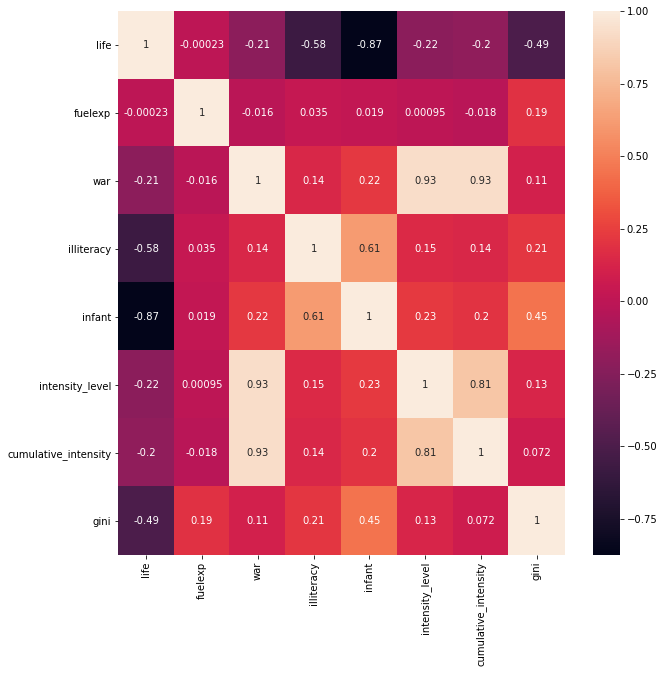

In [87]:
plt.figure(figsize=(10,10))
#df_part_1 = final_df[(final_df.year > 1960) & (final_df.year <= 2000)]
corrMatrix = final_df[wellbeing_features].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

With the current data, we can see no correlation between oil export and any of the variable that is an index of well-being. As a consequence, it does not make sense to look for causation.
The only possibly relevant feature is the gini index. Further integrations of the Gini score into the dataset may be necessary.

## 2. What are the variables that have the most influence in the prediction of a war?

1. Use random forests to predict a war in a country
3. Use the gini index to check the variables' importance - a la replication
4. If gini index seems to be relevant, integrate more data

intensity_level: nan -> 0
cumulative_intensity: 1 - > 2, 0 -> 1, nan -> 0

In [88]:
drop_cols = ['war', 'year', 'country', 'intensity_level', 'cumulative_intensity', 'milper', 'army85', 'sxpsq', 'elfo2', 'ef2']
x_df_no_gini = df_no_gini_clean.drop(drop_cols, axis=1)
y_df_no_gini = df_no_gini_clean.war
x_df_gini = df_gini_clean.drop(drop_cols, axis=1)
y_df_gini = df_gini_clean.war

In [89]:
df_no_gini_clean.war.values.sum()/len(df_no_gini_clean)

0.22898689677213166

In [90]:
df_gini_clean.war.values.sum()/len(df_gini_clean)

0.218609865470852

## Cross Validation

In [91]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.ensemble import  RandomForestClassifier

In [92]:
x_train, x_test, y_train, y_test = train_test_split(x_df_no_gini, y_df_no_gini, test_size=0.2)

In [93]:
# TODO select variables on importance mass e.g. >= 25%

n_estimators_list = range(50, 450, 50) if CFG["cross_val"] else [100]

score_means = []

for e in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=e)
    scores = cross_val_score(rf, x_train, y_train, cv=10, scoring='f1')
    mean_score = np.mean(scores)
    score_means.append((rf, mean_score))
    print (f"n_estimators: {e}, mean score: {mean_score}")

rf_best, _ = max(score_means, key = lambda x : x[1])

n_estimators: 100, mean score: 0.8679904986287934


In [94]:
rf_best.fit(x_train, y_train)
rf_best.score(x_test, y_test)

0.9536741214057508

In [95]:
f1_score(rf.predict(x_test), y_test)

0.8909774436090225

In [96]:
list(reversed(sorted(list(zip(rf_best.feature_importances_, x_train.columns)))))[:25]

[(0.06836175809587551, 'sxpnew'),
 (0.06067831850166091, 'lpopns'),
 (0.040887685572786166, 'trade'),
 (0.037454202929838476, 'nmgdp'),
 (0.03238604308471601, 'illiteracy'),
 (0.03190824948741333, 'agexp'),
 (0.0307903332317854, 'numlang'),
 (0.02867060974757175, 'ehet'),
 (0.02858537195891603, 'expgdp'),
 (0.026726707707263528, 'ln_gdpen'),
 (0.02370164887320201, 'elfo'),
 (0.023581188666605912, 'ptime'),
 (0.022723141352640447, 'popdense'),
 (0.022662096371737033, 'lmtnest'),
 (0.021799474672300947, 'second'),
 (0.021625922751445467, 'tnatwar'),
 (0.0215930596854689, 'fuelexp'),
 (0.020150110815643812, 'infant'),
 (0.019681085268284198, 'dlang'),
 (0.018319438649997532, 'ager'),
 (0.01795422305654678, 'manuexp'),
 (0.01742208461387115, 'geo57'),
 (0.017062918740016406, 'drel'),
 (0.016975465127674103, 'life'),
 (0.01640514065129462, 'avgnabo')]

In [97]:
rf_notest = RandomForestClassifier()
rf_notest.fit(x_df_no_gini, y_df_no_gini)
top_N = 10
top_no_gini = [x[1] for x in 
               reversed(sorted(zip(rf_notest.feature_importances_, x_df_no_gini.columns), key = lambda x : x[0]))][:top_N]
top_no_gini

['sxpnew',
 'lpopns',
 'nmgdp',
 'trade',
 'expgdp',
 'illiteracy',
 'numlang',
 'ln_gdpen',
 'agexp',
 'ehet']

In [98]:
x_train, x_test, y_train, y_test = train_test_split(x_df_gini, y_df_gini, test_size=0.2)

In [99]:
n_estimators_list = range(50, 450, 50) if CFG["cross_val"] else [100]

score_means = []

for e in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=e)
    scores = cross_val_score(rf, x_train, y_train, cv=10, scoring='f1')
    mean_score = np.mean(scores)
    score_means.append((rf, mean_score))
    print (f"n_estimators: {e}, mean score: {mean_score}")

rf_best, _ = max(score_means, key = lambda x : x[1])

n_estimators: 100, mean score: 0.834502082360072


In [100]:
rf_best.fit(x_train, y_train)
rf_best.score(x_test, y_test)

0.9552238805970149

In [101]:
f1_score(rf.predict(x_test), y_test)

0.8991596638655462

In [102]:
list(reversed(sorted(list(zip(rf_best.feature_importances_, x_train.columns)))))[:25]

[(0.06056054702031939, 'illiteracy'),
 (0.04755554297362929, 'sxpnew'),
 (0.04201212807569511, 'ehet'),
 (0.03632618533453266, 'dlang'),
 (0.03527331405681558, 'lpopns'),
 (0.03356068292170047, 'nmgdp'),
 (0.032557016444398124, 'plural'),
 (0.0314604166644778, 'expgdp'),
 (0.030036549998286116, 'trade'),
 (0.027771071672771097, 'numlang'),
 (0.02776057701902985, 'lmtnest'),
 (0.027515017067472825, 'ln_gdpen'),
 (0.02533251005187595, 'agexp'),
 (0.02349595142170137, 'life'),
 (0.021198944063041496, 'ptime'),
 (0.02111221956535904, 'ef'),
 (0.01984571208320935, 'infant'),
 (0.019575755613031785, 'fuelexp'),
 (0.019512151483042806, 'popdense'),
 (0.01922018299577098, 'avgnabo'),
 (0.018895482562861273, 'elfo'),
 (0.018340491711664207, 'seceduc'),
 (0.017844779616838044, 'manuexp'),
 (0.01605388173677812, 'pri'),
 (0.015667583719371152, 'ager')]

In [103]:
rf_notest = RandomForestClassifier()
rf_notest.fit(x_df_gini, y_df_gini)
top_gini = [x[1] for x in 
            reversed(sorted(zip(rf_notest.feature_importances_, x_df_gini.columns), key = lambda x : x[0]))][:top_N]
top_gini

['ehet',
 'illiteracy',
 'sxpnew',
 'lpopns',
 'trade',
 'dlang',
 'nmgdp',
 'expgdp',
 'numlang',
 'ln_gdpen']

## Matching

In [104]:
import statsmodels.formula.api as smf

In [105]:
no_gini_matching = df_no_gini_clean[top_no_gini + ['oil33']]
no_gini_matching

,sxpnew,lpopns,nmgdp,trade,expgdp,illiteracy,numlang,ln_gdpen,agexp,ehet,oil33
16,0.158188,16.435966,1324.000000,11.157030,4.132233,34.163884,8.000000,-0.685179,8.562673,90.00000,0
17,0.158075,16.447903,1351.333374,12.550610,4.453444,34.173826,8.000000,-0.596020,8.560198,90.00000,0
18,0.157719,16.460052,1366.333374,14.227640,4.878051,34.113043,8.000000,-0.576253,8.541015,90.00000,0
19,0.157881,16.471003,1451.333374,26.035509,9.171601,34.163517,8.000000,-0.534435,61.100498,90.00000,0
20,0.157426,16.481419,1610.000000,26.944450,8.888893,34.114133,8.000000,-0.478036,54.437160,90.00000,0
...,...,...,...,...,...,...,...,...,...,...,...
7538,0.175017,16.235174,3132.088135,78.975510,38.148930,15.200000,11.000000,0.236829,6.760000,24.00000,0
7539,0.194624,16.255079,3175.846436,72.737373,36.464649,14.400000,11.000000,0.244755,7.620000,24.00000,0
7540,0.158606,16.274124,4489.731853,79.235222,36.237110,13.600000,11.000000,0.261856,10.590000,24.00000,0
7541,0.157868,16.293167,4516.928076,72.858179,33.606768,12.800000,11.000000,0.244217,8.514664,24.00000,0


In [106]:
gini_matching = df_gini_clean[top_gini + ['oil33']]
gini_matching

,ehet,illiteracy,sxpnew,lpopns,trade,dlang,nmgdp,expgdp,numlang,ln_gdpen,oil33
108,40.00000,18.615999,0.158214,15.005181,72.910596,10.000000,4513.332751,33.647608,6.000000,0.856530,0
109,40.00000,17.907000,0.159307,15.016769,73.068311,10.000000,4483.786223,33.724493,6.000000,0.850482,0
110,40.00000,17.252001,0.157926,15.026502,72.846979,10.000000,4515.625113,33.611062,6.000000,0.857532,0
111,40.00000,16.525000,0.158231,15.036234,72.807813,10.000000,4506.735495,33.607854,6.000000,0.854097,0
112,38.97891,15.951000,0.157975,15.507487,72.745194,23.179975,4511.260173,33.570956,6.035748,0.855102,0
...,...,...,...,...,...,...,...,...,...,...,...
7538,24.00000,15.200000,0.175017,16.235174,78.975510,22.000000,3132.088135,38.148930,11.000000,0.236829,0
7539,24.00000,14.400000,0.194624,16.255079,72.737373,22.000000,3175.846436,36.464649,11.000000,0.244755,0
7540,24.00000,13.600000,0.158606,16.274124,79.235222,22.000000,4489.731853,36.237110,11.000000,0.261856,0
7541,24.00000,12.800000,0.157868,16.293167,72.858179,22.000000,4516.928076,33.606768,11.000000,0.244217,0


In [107]:
top_no_gini_no_fuelexp = [x for x in top_no_gini if x != "fuelexp"]

In [108]:
mod = smf.logit(formula='oil33 ~ ' + ' + '.join(top_no_gini_no_fuelexp), data=no_gini_matching)

res = mod.fit()

# Extract the estimated propensity scores
no_gini_matching.loc[:,('propensity_score')] =res.predict()


Optimization terminated successfully.
         Current function value: 0.181758
         Iterations 8


/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [109]:
import matplotlib.pyplot as plt
#plt.hist(pred_no_gini)

In [110]:
# Defining epsilon
eps=0.1

#Division based on the presence on oil33 or not
treatment_df = no_gini_matching[no_gini_matching['oil33'] == 1]
control_df = no_gini_matching[no_gini_matching['oil33'] == 0]

#function that defines the absolute value of difference of propensity scores
def get_difference(propensity_score1, propensity_score2):
    return np.abs(propensity_score1-propensity_score2)


# function to get matching pairs in treatment and control group
def match_treatment_control(treatment_df, control_df, eps=0.05):
    
    matching={} # empty map to store matching pairs
    matched=set([]) # set to store matched elements from control group

    # iterate through treatment group first as it is the smallest one
    for treatment_id, treatment_row in treatment_df.iterrows():
        lowest_diff=eps
        for control_id, control_row in control_df.iterrows():
            if control_id in matched: 
                continue # skip matched elements


            # Calculate the difference 
            difference = get_difference(control_row['propensity_score'],
                                        treatment_row['propensity_score'])

            # match lowest difference in a greedy manner
            if difference<eps:
                if difference<lowest_diff:
                    matching[treatment_id]=control_id
                    lowest_diff=difference

        # add matched elements to set
        if lowest_diff!=eps: # check if at least one matching was found
            matched.add(matching[treatment_id])

    
    return matching

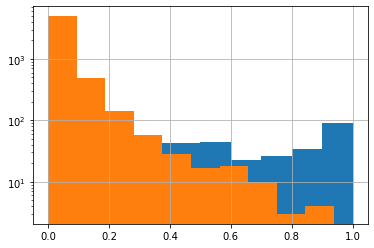

In [111]:
treatment_df['propensity_score'].hist().set_yscale('log')
control_df['propensity_score'].hist().set_yscale('log')
plt.show()

In [112]:
match_no_gini= match_treatment_control(treatment_df, control_df, eps=0.05)

In [113]:
pair_control = control_df.loc[match_no_gini.values()]
pair_treatment = treatment_df.loc[match_no_gini.keys()]

In [114]:
joined.loc[pair_control.index]["country"].unique()

array(['Germany', 'Brazil', 'Kuwait', 'Libya', 'Japan', 'Senegal',
       'Papua New Guinea', 'Netherlands', 'Mauritius', 'Singapore',
       'Zambia', 'Guyana', 'U.S.A.', 'Gambia', 'DR Congo (Zaire)',
       'Bolivia', 'Liberia', 'Tunisia', 'Denmark', 'Belgium',
       'Switzerland', 'Latvia', 'Honduras', 'Nigeria', 'Fiji', 'Greece',
       'Comoros', 'Yemen AR', 'Bahamas', 'Uganda', 'Cuba', 'Sweden',
       'Canada', 'Botswana', 'Mauritania', 'Niger', 'U.K.', 'Colombia',
       'Suriname', 'Togo', 'Russia (Soviet Union)', 'Ghana', 'Italy',
       'Yugoslavia', 'El Salvador', 'Costa Rica', 'Ireland',
       'Ivory Coast', 'Uruguay', 'Luxembourg', 'Burkina Faso', 'Lebanon',
       'Cyprus', 'Iran', 'Bulgaria', 'Australia', 'Malaysia', 'Iraq',
       'Somalia', 'Taiwan', 'Mexico', 'Finland', 'Guatemala', 'Portugal',
       'Romania', 'Myanmar (Burma)', 'Chad', 'Kyrgyzstan', 'Indonesia',
       'Armenia', 'India', 'Mongolia', 'Turkey', 'Syria', 'Sri Lanka',
       'C.A.R.', 'New Zealand'

In [115]:
joined.loc[pair_treatment.index]["country"].unique()

array(['Algeria', 'Angola', 'Bahamas', 'Bahrain', 'Benin', 'Bolivia',
       'Cameroon', 'Chad', 'Colombia', 'Congo (Braz)', 'Ecuador', 'Egypt',
       'Gabon', 'Indonesia', 'Iran', 'Iraq', 'Kenya', 'Kuwait', 'Mexico',
       'Nigeria', 'Norway', 'Oman', 'Panama', 'Papua New Guinea', 'Qatar',
       'Saudi Arabia', 'Senegal', 'Seychelles', 'Singapore', 'Syria',
       'Trinidad and Tobago', 'Tunisia', 'Russia', 'U.A.R.', 'Venezuela',
       'Yemen'], dtype=object)

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


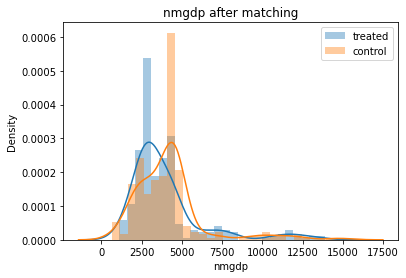

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


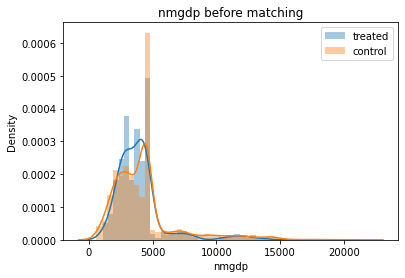

In [116]:
import seaborn as sns
#import matplotlib.pyplot as plt 
pair_control = control_df.loc[match_no_gini.values()]
pair_treatment = treatment_df.loc[match_no_gini.keys()]

ax = sns.distplot(pair_treatment['nmgdp'], hist=True, label='treated');
ax = sns.distplot(pair_control['nmgdp'], hist=True, label='control')
ax.set(title='nmgdp after matching',xlabel='nmgdp')
plt.legend()
plt.show()
ax = sns.distplot(treatment_df['nmgdp'], hist=True, label='treated');
ax = sns.distplot(control_df['nmgdp'], hist=True, label='control')
ax.set(title='nmgdp before matching',xlabel='nmgdp')
plt.legend()
plt.show()

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


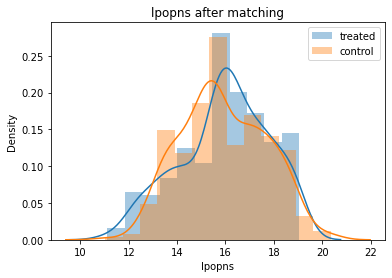

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


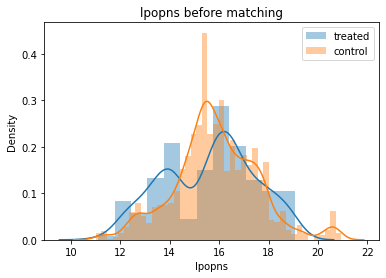

In [117]:
#import matplotlib.pyplot as plt 
pair_control = control_df.loc[match_no_gini.values()]
pair_treatment = treatment_df.loc[match_no_gini.keys()]

ax = sns.distplot(pair_treatment['lpopns'], hist=True, label='treated');
ax = sns.distplot(pair_control['lpopns'], hist=True, label='control')
ax.set(title='lpopns after matching',xlabel='lpopns')
plt.legend()
plt.show()
ax = sns.distplot(treatment_df['lpopns'], hist=True, label='treated');
ax = sns.distplot(control_df['lpopns'], hist=True, label='control')
ax.set(title='lpopns before matching',xlabel='lpopns')
plt.legend()
plt.show()

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


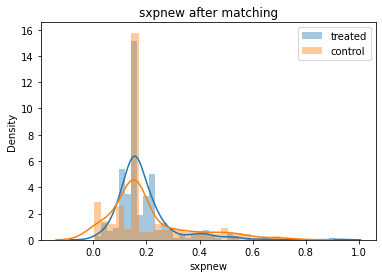

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


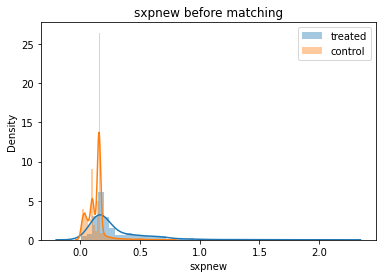

In [118]:
#import matplotlib.pyplot as plt 
pair_control = control_df.loc[match_no_gini.values()]
pair_treatment = treatment_df.loc[match_no_gini.keys()]

ax = sns.distplot(pair_treatment['sxpnew'], hist=True, label='treated');
ax = sns.distplot(pair_control['sxpnew'], hist=True, label='control')
ax.set(title='sxpnew after matching',xlabel='sxpnew')
plt.legend()
plt.show()
ax = sns.distplot(treatment_df['sxpnew'], hist=True, label='treated');
ax = sns.distplot(control_df['sxpnew'], hist=True, label='control')
ax.set(title='sxpnew before matching',xlabel='sxpnew')
plt.legend()
plt.show()

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


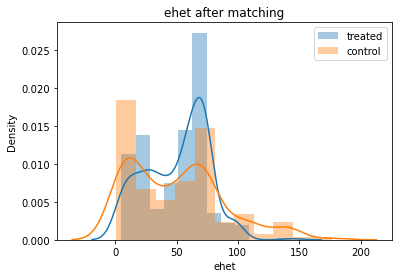

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


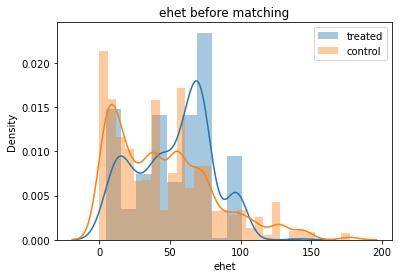

In [119]:
#import matplotlib.pyplot as plt 
pair_control = control_df.loc[match_no_gini.values()]
pair_treatment = treatment_df.loc[match_no_gini.keys()]

ax = sns.distplot(pair_treatment['ehet'], hist=True, label='treated');
ax = sns.distplot(pair_control['ehet'], hist=True, label='control')
ax.set(title='ehet after matching',xlabel='ehet')
plt.legend()
plt.show()
ax = sns.distplot(treatment_df['ehet'], hist=True, label='treated');
ax = sns.distplot(control_df['ehet'], hist=True, label='control')
ax.set(title='ehet before matching',xlabel='ehet')
plt.legend()
plt.show()

### Comment about matching
Looking at the four most influential features for the war we can see that the matching create a good balance between treatment (country-year with oil33 equal to 1) group and control group.

In [120]:
pair_treatment[['war', 'intensity_level']] = df_no_gini_clean[['war','intensity_level']].loc[pair_treatment.index]
pair_control[['war', 'intensity_level']] = df_no_gini_clean[['war', 'intensity_level']].loc[pair_control.index]

In [121]:
#Function to calculate bootstrap confidence intervals
def bootstrap_CI(data, nbr_draws, func, lo_qt=2.5, hi_qt=97.5):
    probs = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        probs[n] = func(data_tmp) # apply function

    return np.nanpercentile(probs, lo_qt), np.nanpercentile(probs, hi_qt), probs.mean()

In [122]:
differences_y=pair_treatment['war'].values-pair_control['war'].values
ATE = np.mean(differences_y)
lo_ATE,up_ATE,_=bootstrap_CI(differences_y, 1000, lambda x : x.mean(), lo_qt=2.5, hi_qt=97.5)
print(f"ATE is equal to: {ATE:.3}, the 95%-confidence interval is ({lo_ATE:.3},{up_ATE:.3})")

ATE is equal to: 0.188, the 95%-confidence interval is (0.13,0.246)


### Comment about result (ATE)
The ATE obtained shows that there is evidence of a weak influence of oil exportation in the presence of war in a country.

In [123]:
pair_treatment['intense_war']=pair_treatment['intensity_level'].apply(lambda i: max(i-1,0))
pair_control['intense_war']=pair_control['intensity_level'].apply(lambda i: max(i-1,0))

In [124]:
differences_y=pair_treatment['intense_war'].values-pair_control['intense_war'].values
ATE = np.mean(differences_y)
lo_ATE,up_ATE,_=bootstrap_CI(differences_y, 1000, lambda x : x.mean(), lo_qt=2.5, hi_qt=97.5)
print(f"ATE is equal to: {ATE:.3}, the 95%-confidence interval is ({lo_ATE:.3},{up_ATE:.3})")

ATE is equal to: 0.0841, the 95%-confidence interval is (0.0464,0.119)


### Matching on Gini

In [125]:
top_gini_no_fuelexp = [x for x in top_gini if x != "fuelexp"]

In [126]:
mod = smf.logit(formula='oil33 ~ ' + ' + '.join(top_gini_no_fuelexp), data=gini_matching)

res = mod.fit()

# Extract the estimated propensity scores
gini_matching.loc[:,('propensity_score')] =res.predict()


Optimization terminated successfully.
         Current function value: 0.173947
         Iterations 8


/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [127]:
#Division based on the presence on oil33 or not
treatment_df = gini_matching[gini_matching['oil33'] == 1]
control_df = gini_matching[gini_matching['oil33'] == 0]

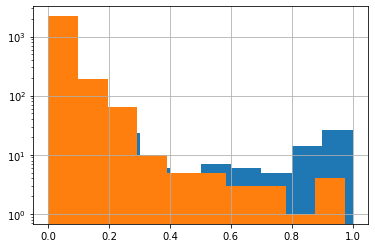

In [128]:
treatment_df['propensity_score'].hist().set_yscale('log')
control_df['propensity_score'].hist().set_yscale('log')
plt.show()

In [129]:
match_gini= match_treatment_control(treatment_df, control_df, eps=0.05)

In [130]:
len(match_gini)

145

In [131]:
pair_control = control_df.loc[match_gini.values()]
pair_treatment = treatment_df.loc[match_gini.keys()]
# TODO list zipped pairs

In [132]:
joined.loc[pair_control.index]["country"].unique()

array(['Australia', 'New Zealand', 'Singapore', 'Greece', 'Ivory Coast',
       'Sri Lanka', 'Belgium', 'Germany', 'U.S.A.', 'Iran', 'Sweden',
       'Liberia', 'Uganda', 'Norway', 'Botswana', 'DR Congo (Zaire)',
       'Jordan', 'Bulgaria', 'Morocco', 'Lithuania', 'Yugoslavia',
       'Senegal', 'Zambia', 'Japan', 'Chile', 'Mozambique', 'Jamaica',
       'Austria', 'China', 'Togo', 'Korea, South', 'Mauritius', 'Moldova',
       'Gabon', 'Israel', 'Netherlands', 'Russia (Soviet Union)',
       'Argentina', 'Estonia', 'Iceland', 'U.K.', 'Peru', 'Brazil',
       'C.A.R.', 'Denmark', 'Georgia', 'Ethiopia', 'Slovenia',
       'Bosnia-Herzegovina', 'Libya', 'Honduras', 'Canada', 'Spain',
       'France', 'Taiwan', 'Malaysia', 'Mongolia', 'Costa Rica',
       'Kazakhstan', 'Lesotho', 'Uruguay', 'Finland', 'Lebanon',
       'Philippines'], dtype=object)

In [133]:
joined.loc[pair_treatment.index]["country"].unique()

array(['Algeria', 'Angola', 'Bahamas', 'Bahrain', 'Bolivia', 'Cameroon',
       'Colombia', 'Congo (Braz)', 'Ecuador', 'Egypt', 'Gabon',
       'Indonesia', 'Iran', 'Kuwait', 'Mexico', 'Nigeria', 'Norway',
       'Oman', 'Qatar', 'Saudi Arabia', 'Singapore', 'Syria',
       'Trinidad and Tobago', 'Tunisia', 'Russia', 'Venezuela', 'Yemen'],
      dtype=object)

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


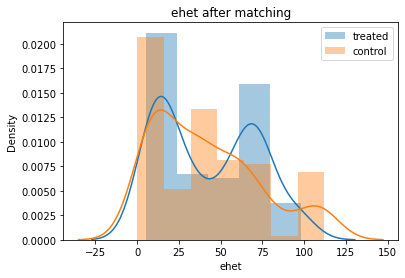

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


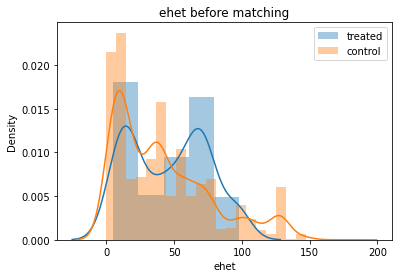

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


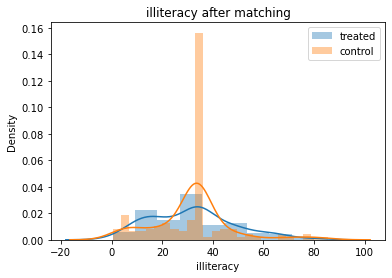

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


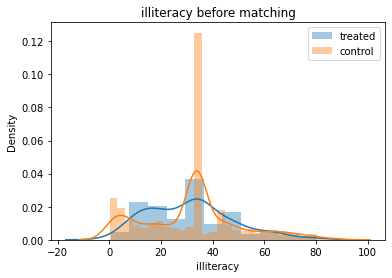

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


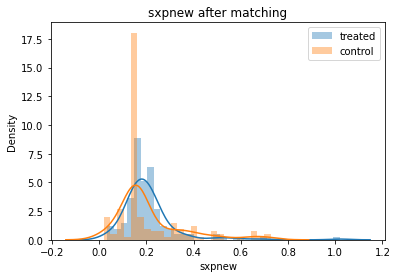

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


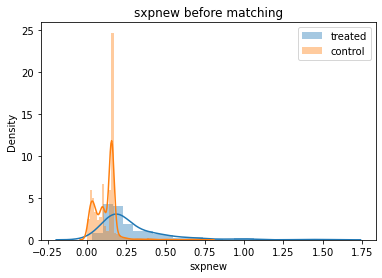

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


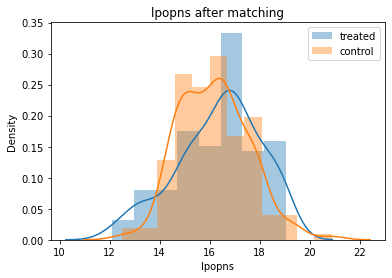

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


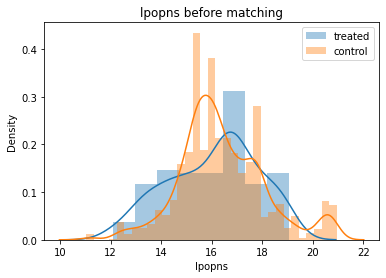

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


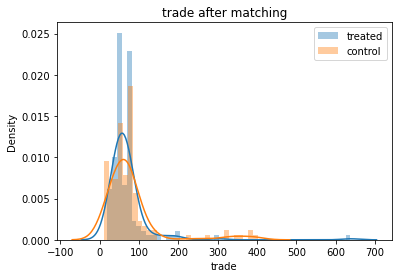

/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giorgio/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


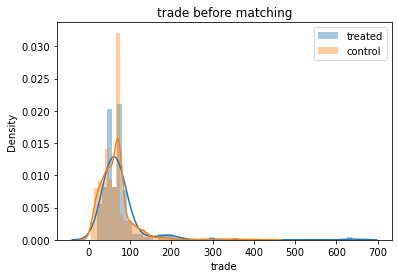

In [134]:

for var in top_gini[:5]:
    ax = sns.distplot(pair_treatment[var], hist=True, label='treated');
    ax = sns.distplot(pair_control[var], hist=True, label='control')
    ax.set(title=f'{var} after matching',xlabel=var)
    plt.legend()
    plt.show()
    ax = sns.distplot(treatment_df[var], hist=True, label='treated');
    ax = sns.distplot(control_df[var], hist=True, label='control')
    ax.set(title=f'{var} before matching',xlabel=var)
    plt.legend()
    plt.show()

In [135]:
pair_treatment[['war', 'intensity_level']] = df_gini_clean[['war','intensity_level']].loc[pair_treatment.index]
pair_control[['war', 'intensity_level']] = df_gini_clean[['war', 'intensity_level']].loc[pair_control.index]

In [136]:
differences_y=pair_treatment['war'].values-pair_control['war'].values
ATE = np.mean(differences_y)
lo_ATE,up_ATE,_=bootstrap_CI(differences_y, 1000, lambda x : x.mean(), lo_qt=2.5, hi_qt=97.5)
print(f"ATE is equal to: {ATE:.3}, the 95%-confidence interval is ({lo_ATE:.3},{up_ATE:.3})")

ATE is equal to: 0.172, the 95%-confidence interval is (0.0897,0.262)
